<img src="mioti.png" style="height: 100px">
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Data preprocessing</center>

# Worksheet S1: Introducción al preprocesamiento de datos

## Objetivos

El objetivo de este worksheet es que aprendas los métodos más comunes de preprocesamiento de datos.

* Técnicas básicas de exploración de un dataset
* Filtrado de datos
* Visualización de datos
* Tratamiento de outliers
* Imputación de valores ausentes
* Muestreo

## Configuración del entorno

Es recomendable declarar en un bloque al principio todos los paquetes que vamos a utilizar en este notebook:

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Carga de los datos

Para este worksheet vamos a hacer uso de un dataset público de temperaturas globales de la tierra disponible desde:

https://datahub.io/core/global-temp

Los datos corresponden a datos mensuales de la temperatura media de la tierra medida medidos con 2 sistemas distintos.

La descripción de cada una de las columnas es la siguiente:

<img src="global_temp_data.png">

Los datos se encuentran en un fichero `csv` llamado `monthly.csv`.

Para cargar los datos utilizaremos la función read_csv que nos proporciona la libreria de pandas para cargar una base de datos de usuarios en un dataframe que llamaremos `df`.

In [2]:
df = pd.read_csv('monthly.csv')

Una vez cargados los datos debemos inspeccionarlos antes de empezar nuestro análisis.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3288 entries, 0 to 3287
Data columns (total 3 columns):
Source             3288 non-null object
Date               3288 non-null object
MeanTemperature    3288 non-null float64
dtypes: float64(1), object(2)
memory usage: 77.2+ KB


Podemos ver que este dataset contiene 3288 instancias, con 3 columnas.

Por cada columna podemos ver el tipo que lo ha cargado.

## Navegación en el dataframe

Antes de empezar a realizarnos preguntas o hacer transformaciones sobre los datos, debemos comprender que estructura tienen. Para ello podemos hacer uso de las funciones `head`, `index` y `columns` para ver la estructura del dataset.

In [4]:
df.head() # Nos devuelve los 5 primeros registros del df

,Source,Date,MeanTemperature
0,GCAG,2016-12-26,0.7895
1,GISTEMP,2016-12-26,0.8100
2,GCAG,2016-11-26,0.7504
3,GISTEMP,2016-11-26,0.9300
4,GCAG,2016-10-26,0.7292


In [5]:
df.columns # Nos da información sobre las columnas

Index(['Source', 'Date', 'MeanTemperature'], dtype='object')

In [6]:
df.describe(percentiles=[.01, .05, .5, .95, .99])

,MeanTemperature
count,3288.000000
mean,0.038610
std,0.439494
min,-10.677400
1%,-0.549552
5%,-0.410065
50%,-0.036650
95%,0.686350
99%,0.883552
max,10.521800


Podemos acceder a una columna individual mediante:

In [7]:
df['MeanTemperature'].head()

0    0.7895
1    0.8100
2    0.7504
3    0.9300
4    0.7292
Name: MeanTemperature, dtype: float64

o también mediante:

In [8]:
df.MeanTemperature.head()

0    0.7895
1    0.8100
2    0.7504
3    0.9300
4    0.7292
Name: MeanTemperature, dtype: float64

## Filtrado de datos
Una particularidad de este dataset es que contiene información de dos fuentes distintas. Cada instancia del dataset viene identificada con el sistema de procedencia mediante la columna `Source`. Podemos consultar la distribución de las mismas así:

In [9]:
df.Source.value_counts()

GCAG       1644
GISTEMP    1644
Name: Source, dtype: int64

En este caso vamos a trabajar sólo con las mediciones de la fuente 'GCAG', para ello vamos a filtrar los datos. Lo podemos hacer de la siguiente manera:

In [10]:
df = df[df['Source'] == 'GCAG']

De esta manera hemos filtrado los datos y podemos ver el resultado:

In [11]:
df.head()

,Source,Date,MeanTemperature
0,GCAG,2016-12-26,0.7895
2,GCAG,2016-11-26,0.7504
4,GCAG,2016-10-26,0.7292
6,GCAG,2016-09-26,0.8767
8,GCAG,2016-08-26,0.8998


### Pregunta

* ¿Por qué en la primera columna sólo aparecen números pares? ¿Qué es la primera columna?

## Visualización de datos
Una técnica que nos ayuda mucho a visualizar los datos es el uso de gráficos. Podemos dibujar gráficos con `pandas` de forma muy sencilla.

Si queremos un gráfico de línea lo podemos hacer de la siguiente manera:

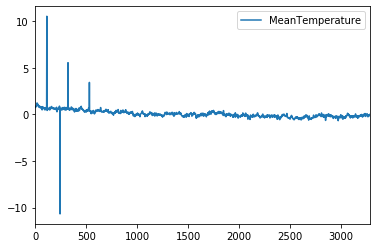

In [12]:
df.plot.line()

Si queremos hacer un histograma es igual de sencillo:

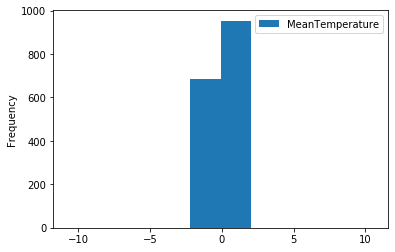

In [13]:
df.plot.hist()

Por defecto `pandas` crea los histogramas con 10 bins. Si queremos ampliar el número es tan fácil como:

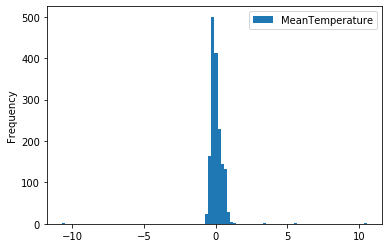

In [14]:
df.plot.hist(bins=100)

### Preguntas

* ¿Podrías describir que es un histograma?
* ¿Qué nos está diciendo estos dos gráficos sobre los datos?

## Tratamiento de outliers

Como hemos podido ver en los gráficos anteriores los datos contienen outliers que nos impiden visualizar los datos correctamente.

### ¿Qué es un outlier?.

Un outlier es un dato anómalo que está fuera de rango y sobresale de los demás. Generalmente los outliers están producidos por:

* Situaciones atípicas
* Errores de medición 
* Errrores de interpretación

Es muy importante antes de realizar un análisis estadístico o de entrenar un modelo, identificar y neutralizar los outliers, porque hay muchos métodos muy sensibles a outliers y la presencia de estos puede distorsionar el resultado.

Por ejemplo si hacemos una regresión lineal con un conjunto de datos con y sin outliers los resultados pueden ser muy distintos.

<img src="outliers.jpg">

Uno de los métodos más clásicos de detección de outliers es el método de tukey. Éste consiste en identificar los outliers como aquellos puntos que se salgan de la "normalidad" de los datos.

En este caso definimos un outlier como cualquier punto que sea inferior a $Q_1 - 1.5 \times IQR$ o superior a $Q_3 + 1.5 \times IQR$.

* donde $IQR$ es el rango intercuartílico $Q_3 - Q_1$
* y $Q_n$ es el cuartil $n$ de los datos.
        
<img src="boxplot.jpg">

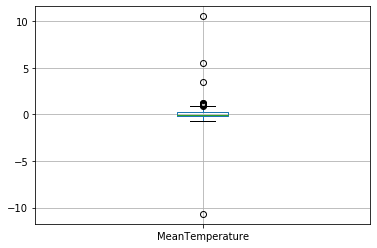

In [15]:
df.boxplot('MeanTemperature')

Podemos implementar el método de tukey de la siguiente manera:

In [16]:
def filtrar_outlier_tukey(x):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3 - q1 
    print("[q1=%f, q3=%f, iqr=%f]" % (q1, q3, iqr))
    
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    print("[floor=%f, ceiling=%f]" % (floor, ceiling))
    
    outlier_indices = list(x.index[(x < floor)|(x > ceiling)])
    outlier_values = list(x[outlier_indices])

    return outlier_indices, outlier_values

Y podemos aplicarlo a la columna `MeanTemperature` así:

In [17]:
outlier_indices, outlier_values = filtrar_outlier_tukey(df.MeanTemperature)

[q1=-0.191400, q3=0.251000, iqr=0.442400]
[floor=-0.855000, ceiling=0.914600]


Esto nos devuelve dos listas:

* `outlier_indices`: Una lista de las posiciones que ocupan los outliers.
* `outlier_values`: Los valores de los elementos que se han clasificado como outliers.

In [18]:
print(outlier_indices)
print(outlier_values)

[16, 18, 20, 22, 24, 26, 28, 30, 114, 244, 322, 532]
[1.0733, 1.2245, 1.1921, 1.0569, 1.1219, 0.9655, 0.9913, 0.926, 10.5218, -10.6774, 5.5408, 3.4273]


Una vez identificados los outliers podemos eliminarlos de la siguiente manera:

In [19]:
for index in outlier_indices:
    df.MeanTemperature.at[index] = np.nan

En este caso, lo que hemos hecho es poner un valor nulo `np.nan` en cada posición que contiene un outlier.

Un vez eliminados los outliers podemos dibujar de nuevo el gráfico:

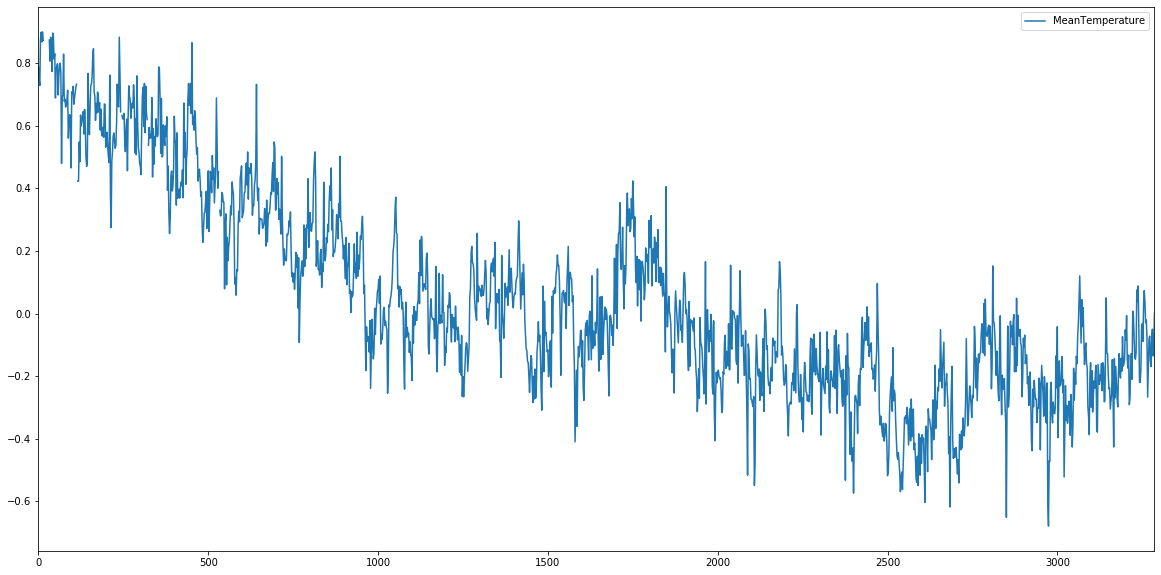

In [20]:
df.plot.line(figsize=[20,10])

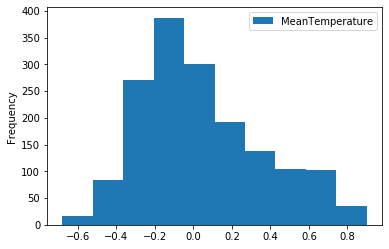

In [21]:
df.plot.hist()

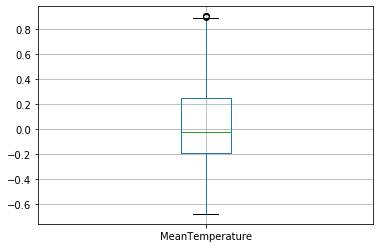

In [22]:
df.boxplot('MeanTemperature')

In [23]:
_, _ = filtrar_outlier_tukey(df.drop(outlier_indices, axis=0).MeanTemperature)

[q1=-0.191725, q3=0.243300, iqr=0.435025]
[floor=-0.844263, ceiling=0.895837]


In [24]:
df.drop(outlier_indices, axis=0).MeanTemperature.sort_values().tail()

238    0.8839
44     0.8843
42     0.8969
8      0.8998
12     0.9006
Name: MeanTemperature, dtype: float64

### Preguntas

* ¿Qué ha pasado en los gráficos después de eliminar outliers?
* ¿Por qué aparecen outliers en el último box plot?
* ¿Crees que es adecuado el método de eliminación de outliers con los datos que tenemos? ¿Qué podríamos hacer para mejorarlo?

## Imputación de valores ausentes
En los pasos anteriores hemos identificado los outliers y los hemos asignado a un valor nulo.

In [25]:
for index in outlier_indices:
    print("[%s] %f" % (index, df.loc[index].MeanTemperature))

[16] nan
[18] nan
[20] nan
[22] nan
[24] nan
[26] nan
[28] nan
[30] nan
[114] nan
[244] nan
[322] nan
[532] nan


Otra forma de ver esta información agregada a nivel de columna es de la siguiente manera:

In [26]:
df.isnull().sum()

Source              0
Date                0
MeanTemperature    12
dtype: int64

Ahora en este paso lo que vamos a hacer es darles un valor a los outliers para tener un dataset sin valores nulos. Una técnica bastante habitual con datos numéricos es asignar la **media aritmética** de la serie a los valores nulos.

En este caso vamos a utilizar `sklearn` para hacerlo y vamos a utilizar una clase que nos facilita esta tarea que se denomina `Imputer`. Este método nos sustituirá todos los valores nulos por el valor de la mediana de la columna.

In [27]:
from sklearn.impute import SimpleImputer

# SimpleImputer nos pide un input 2D (una matriz)
# así que tenemos que transformar nuestros valores primero.
temp_values = df.MeanTemperature.values.reshape(-1,1)
#temp_values = df.MeanTemperature.values

imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
imp_mean.fit(temp_values)
transformed_values = imp_mean.transform(temp_values)

Una vez hecho esto, en `transformed_values` disponemos de los datos con los valores nulos rellenos.

In [28]:
df.MeanTemperature = transformed_values

In [29]:
for index in outlier_indices:
    print("[%s] %f" % (index, df.loc[index].MeanTemperature))

[16] -0.023950
[18] -0.023950
[20] -0.023950
[22] -0.023950
[24] -0.023950
[26] -0.023950
[28] -0.023950
[30] -0.023950
[114] -0.023950
[244] -0.023950
[322] -0.023950
[532] -0.023950


In [30]:
df.MeanTemperature.median()

-0.02395

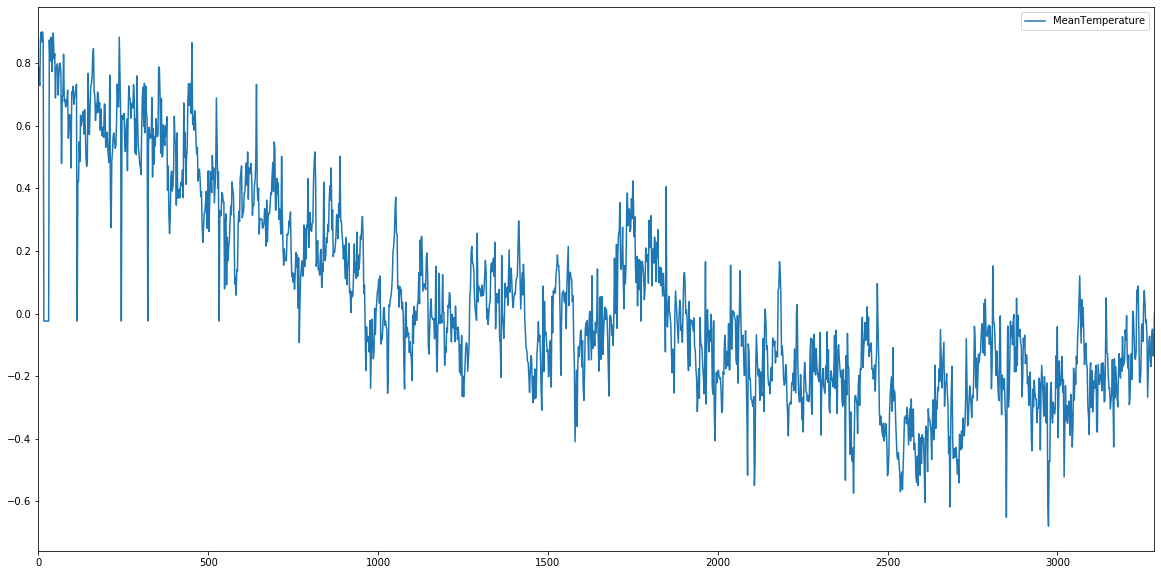

In [31]:
df.plot.line(figsize=[20,10])

### Preguntas

* ¿Se te ocurre un método de imputación de datos mejor?
* ¿Ves alguna relación entre el problema de imputación de valores nulos y la detección de outliers?

## Muestreo

Otra aplicación básica en tareas de proprocesado es la reducción de datos. Por ejemplo este dataset contiene una muestra con una frecuencia mensual. En este caso para evitar la estacionalidad anual nos podría interesar agrupar los datos a nivel anual, esto lo podemos hacer con la función `resample` de `pandas`

Antes de aplicarla tenemos que hacer algo de preprocesado previo.

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1644 entries, 0 to 3286
Data columns (total 3 columns):
Source             1644 non-null object
Date               1644 non-null object
MeanTemperature    1644 non-null float64
dtypes: float64(1), object(2)
memory usage: 131.4+ KB


Como podemos ver el indexado de este dataframe está basado en un entero ficticio que ha generado pandas automáticamente al cargar el dataframe.

Además podemos ver que la columna `Date` pandas la ha cargado con tipo `object`, esto significa que a efectos prácticos se está tratando esa columna como una cadena de texto y no como una fecha.

Podemos realizar la conversión de la columna de la siguiente manera:

In [33]:
df.Date = pd.to_datetime(df.Date)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1644 entries, 0 to 3286
Data columns (total 3 columns):
Source             1644 non-null object
Date               1644 non-null datetime64[ns]
MeanTemperature    1644 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 131.4+ KB


Podemos ver ahora que `Date` ya se está interpretando como una columna de tipo `datetime` con precisión de 64 bits.

El segundo requisito que necesita `pandas` para realizar resampling cómodamente es que el indexing de la columna sea de tipo datetime, esto lo podemos hacer de la siguiente manera:

In [35]:
df.index = df.Date
df.head()

,Source,Date,MeanTemperature
Date,,,
2016-12-26,GCAG,2016-12-26,0.7895
2016-11-26,GCAG,2016-11-26,0.7504
2016-10-26,GCAG,2016-10-26,0.7292
2016-09-26,GCAG,2016-09-26,0.8767
2016-08-26,GCAG,2016-08-26,0.8998


Ahora ya podemos utilizar la función resample. Podemos consultar sus parámetros en: https://stackoverflow.com/questions/17001389/pandas-resample-documentation

In [36]:
df.resample('A').mean().head()

,MeanTemperature
Date,
1880-12-31,-0.114767
1881-12-31,-0.062825
1882-12-31,-0.064833
1883-12-31,-0.142417
1884-12-31,-0.200933


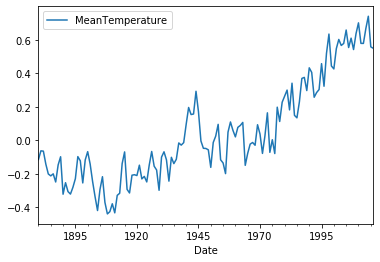

In [37]:
df.resample('A').mean().plot.line()

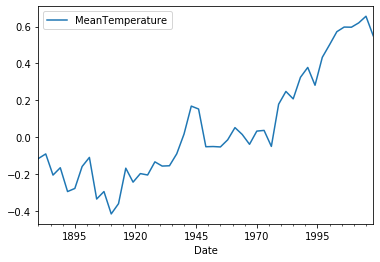

In [38]:
df.resample('3A').mean().plot.line()

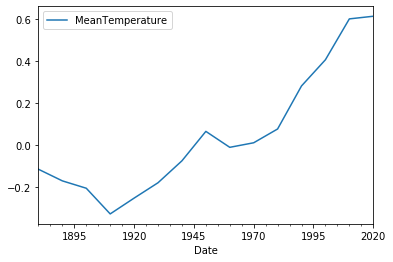

In [39]:
df.resample('10A').mean().plot.line()

## Quizz



* ¿Qué conclusiones sacas de estos datos?
* Si tuvieras que hacer una _check list_ que revisar al cargar un dataset, ¿cual sería?